<a href="https://colab.research.google.com/github/quochungtran/NLP-with-Disaster-Tweets/blob/master/Tweet_NLP_disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mout with gg drive**

In [7]:
# connect gitlab to drive to be a place to store data
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
cd /content/drive/MyDrive/NLP-with-Disaster-Tweets


/content/drive/MyDrive/NLP-with-Disaster-Tweets


# **Setting up** 

In [15]:
#Importing the required libraries to read,visualize and model the givn dataset files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno 
import warnings
import os

warnings.filterwarnings("ignore")
import re
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
import nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from platform import python_version
print (python_version())

3.9.16


# **Prolem statement** 

1. Data exploratory analysis: This section will cover the basics of data exploration. 


2. Data preprocessing: This section will cover the basics of data cleaning and preparation, such as removing missing values and splitting the data into train and test sets.

3. Text processing and feature extraction: This section will cover the basics of text processing and feature extraction using NLP techniques, such as tokenization, stopword removal, and stemming. It will also introduce the concept of feature engineering, such as creating new features based on existing data.

4. Machine learning model selection: This section will cover the basics of selecting a machine learning model and evaluating its performance, such as using different models, hyperparameter tuning, and model selection based on performance metrics.

5. Model evaluation and performance: This section will cover the basics of evaluating the performance of a machine learning model, such as using metrics like accuracy, precision, recall, and F1-score, and understanding the trade-offs between different metrics.

In [10]:
# defining path 

DATA_FOLDER   = "./data"
TRAINING_PATH = "./data/train.csv"
TESTING_PATH  = "./data/test.csv" 

In [17]:
for dir_name, _,filenames in os.walk(DATA_FOLDER):
  for filename in filenames:
    print(os.path.join(dir_name, filename))

./data/train.csv
./data/test.csv
./data/sample_submission.csv


In [53]:
df_train = pd.read_csv(TRAINING_PATH)
df_test  = pd.read_csv(TESTING_PATH)

In [19]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## **Data exploratory analysis**



In [20]:
# data peeking 
print(f'Shape of the File : {df_train.shape}\n')
print(f'All the Columns of the Dataframe : \n\n{df_train.columns.values}')
# values methods save data under list form 

Shape of the File : (7613, 5)

All the Columns of the Dataframe : 

['id' 'keyword' 'location' 'text' 'target']


### Data description

- id - a unique identifier for each tweet

- text - the text of the tweet

- location - the location the tweet was sent from (may be blank)

- keyword - a particular keyword from the tweet (may be blank)

- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Text(0.5, 1.0, 'Target Value Counts in training data set')

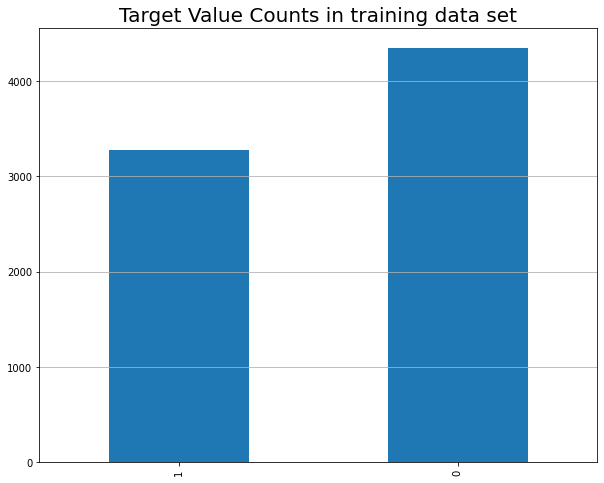

In [21]:
# ploting class distribution between train and test set
fig = plt.figure(figsize=(10,8))
ax = df_train['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
ax.set_title("Target Value Counts in training data set", fontsize=20)

In [22]:
# missing data
def missing_values(df) :
    print("Number of data points in data set  : ", df.shape[0])
    print("Number of missing data for column keyword : ", df['keyword'].isna().sum())
    print("Number of missing data for column location: ", df['location'].isna().sum())
    print(f"{round(df.keyword.isnull().sum()/(df.shape[0])*100,2)} %  of missing keywork values in entire of data")
    print(f"{round(df.location.isnull().sum()/(df.shape[0])*100,2)} % of missing location values in entire of data")

In [32]:
missing_values(df_train)

Number of data points in data set  :  7613
Number of missing data for column keyword :  61
Number of missing data for column location:  2533
0.8 %  of missing keywork values in entire of data
33.27 % of missing location values in entire of data


In [24]:
missing_values(df_test)

Number of data points in data set  :  3263
Number of missing data for column keyword :  26
Number of missing data for column location:  1105
0.8 %  of missing keywork values in entire of data
33.86 % of missing location values in entire of data


In [55]:
# fill missing value to indicate 
for df in [df_train, df_test]:
    for col in ["keyword", "location"]:
        df[col] = df[col].fillna(f"no_{col}")


In [37]:
# check duplicate data 
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


### Keyword features

(array([ 4.,  0.,  1.,  1.,  3., 18., 80., 70., 41.,  3.]),
 array([ 9. , 12.6, 16.2, 19.8, 23.4, 27. , 30.6, 34.2, 37.8, 41.4, 45. ]),
 <BarContainer object of 10 artists>)

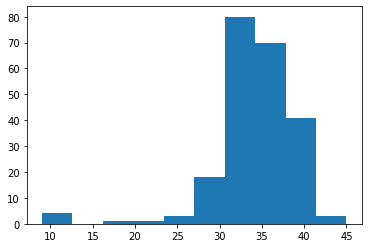

In [26]:
plt.hist(df_train["keyword"].value_counts())

In [38]:
# the most commently keyword appeared in our data set

feat=df_train['keyword'].value_counts()
print(feat.head())
fig = px.scatter(feat, x=feat.values, y=feat.index,size=feat.values)
fig.show()

no_keyword    61
fatalities    45
deluge        42
armageddon    42
sinking       41
Name: keyword, dtype: int64


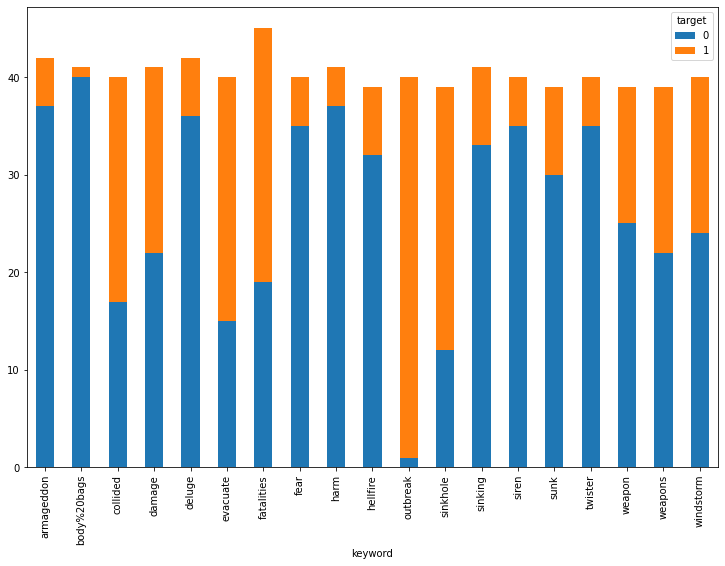

In [104]:

most_count_keyword = df_train["keyword"].value_counts().keys()[1:20]
df_count_most_values = df_train[df_train.keyword.isin(most_count_keyword)]
grouped = df_count_most_values.groupby(['keyword', 'target']).size().reset_index(name='Count')
pivot_table = grouped.pivot(index='keyword', columns='target', values='Count')

# Create a new figure object with a larger size
fig, ax = plt.subplots(figsize=(12, 8))
pivot_table.plot.bar(stacked=True, ax=ax)

# Adjust the subplot spacing
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

Remark:
In data set:
- **outbreak** consided to be "real-disaster" word. 
- **amargedon, body%20bag, harm, sinking, twister** tend to "non-disaster" word 

### Location features

In [109]:
df_train['location'].value_counts()

no_location                     2533
USA                              445
UK                               118
Africa                            51
India                             46
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3313, dtype: int64

In [49]:
# missing value are not visualized in the graph

feat=df_train['location'].value_counts()
print(feat.head())
fig = px.scatter(feat, x=feat.values, y=feat.index,size=feat.values)
fig.show()

no_location      2533
USA               104
New York           71
United States      50
London             45
Name: location, dtype: int64


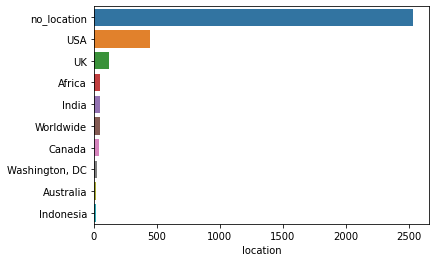

In [56]:
# Replacing the ambigious locations name with standard names and create a dictionary object
loc_dict = {"United States":'USA',
            "New York":'USA',
            "London":'UK',
            "Los Angeles, CA":'USA',
            "Washington, D.C.":'USA',
            "California":'USA',
            "Chicago, IL":'USA',
            "Chicago":'USA',
            "New York, NY":'USA',
            "California, USA":'USA',
            "FLorida":'USA',
            "San Francisco":'USA',
            "Florida":'USA',
            "Los Angeles":'USA',
            "San Francisco, CA":'USA',
            "NYC":'USA',
            "New York City":'USA',
            "Texas":'USA',
            "Atlanta, GA":'USA',
            "Seattle":'USA',

            "Nigeria":'Africa',
            "Kenya":'Africa',

            "Everywhere":'Worldwide',
            "Earth":'Worldwide',

            "Toronto":'Canada',

            "United Kingdom":'UK',
            "Ireland":'UK',
            "London, England":'UK',
            "London, UK":'UK',
            "Mumbai":"India"
            
            # todo             
}

# replace() method takes a dictionary that maps old values to new values. 
df_train['location'].replace(loc_dict,inplace=True)


#Create barchart for top 10 locations using seaborn
sns.barplot(y=df_train['location'].value_counts()[:10].index,x=df_train['location'].value_counts()[:10],
          orient='h');


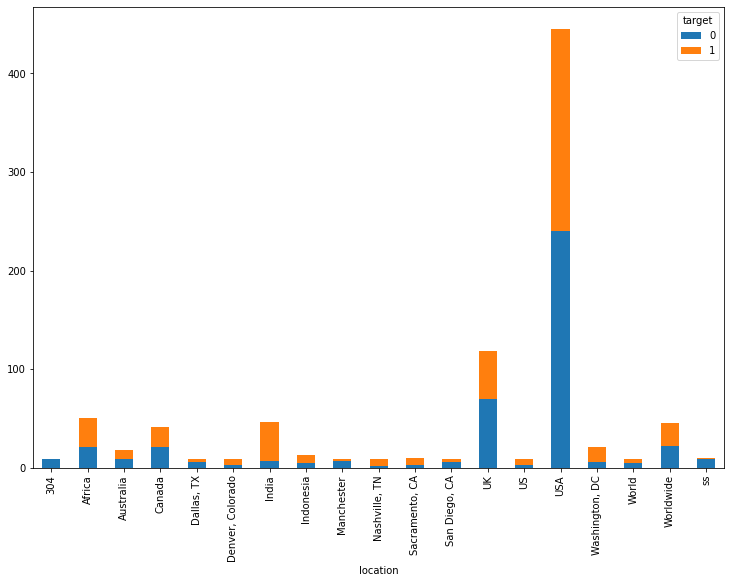

In [106]:
most_count_loc = df_train["location"].value_counts().keys()[1:20]
df_most_count_loc = df_train[df_train.location.isin(most_count_loc)]
grouped = df_most_count_loc.groupby(['location', 'target']).size().reset_index(name='Count')
pivot_table = grouped.pivot(index='location', columns='target', values='Count')

# Create a new figure object with a larger size
fig, ax = plt.subplots(figsize=(12, 8))
pivot_table.plot.bar(stacked=True, ax=ax)

# Adjust the subplot spacing
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

Because it contains a large missing values in term of location features, we will drop and exculde this feature from further analysis and modeling  

In [57]:
df_train["location"].unique()

array(['no_location', 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

### Length of each tweet sentence

Investigate and visualize length of tweets in the file available.

In [58]:
df_train["tweet_len"] = df_train["text"].apply(lambda x : len(x))
df_train.head()

,id,keyword,location,text,target,tweet_len
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,38
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,133
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,65
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,88


In [59]:
df_train["tweet_len"].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: tweet_len, dtype: float64

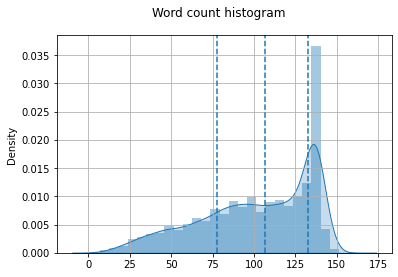

In [60]:
sns.distplot(df_train['tweet_len'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(df_train['tweet_len'].describe()['25%'], ls="--")
plt.axvline(df_train['tweet_len'].describe()['50%'], ls="--")
plt.axvline(df_train['tweet_len'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word count histogram")
plt.show()

See how distribution of tweet len comparasion to target value

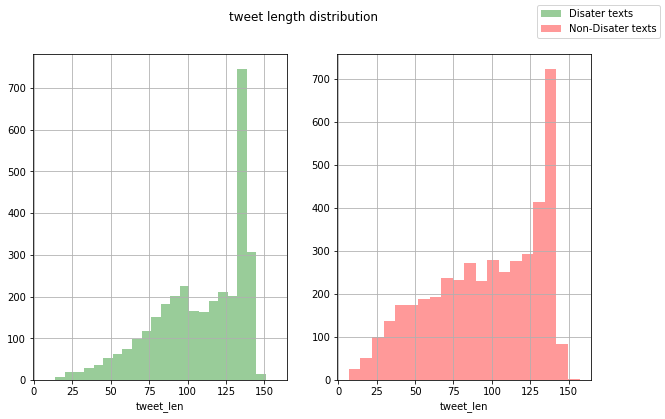

In [62]:
fig, (ax1, ax2) =  plt.subplots(1, 2, sharex=True,figsize=(10,6))
sns.distplot(df_train[(df_train['target'] == 1)]['tweet_len'], ax=ax1, kde=False, color='green',label='Disater texts')
sns.distplot(df_train[(df_train['target'] == 0)]['tweet_len'],ax=ax2, kde=False, color='red',label='Non-Disater texts');
fig.suptitle('tweet length distribution')
fig.legend(loc='upper right')
ax1.grid()
ax2.grid()
plt.show()

### Length of words in each tweet sentence

In [110]:
df_train["tweet_words_count"] = df_train["text"].str.split().apply(lambda x : len(x))
df_train.head()

,id,keyword,location,text,target,tweet_len,tweet_words_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,133,22
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,88,16


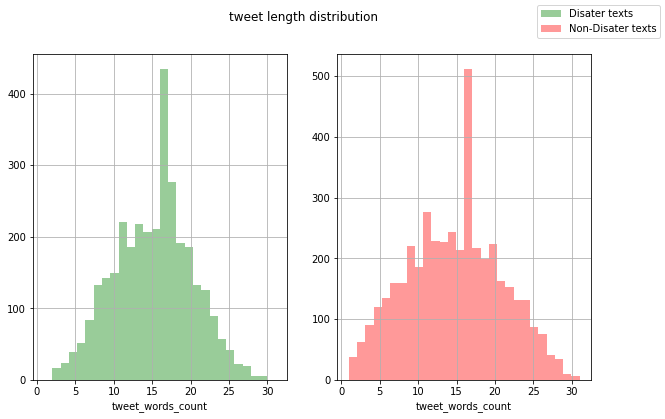

In [111]:
fig, (ax1, ax2) =  plt.subplots(1, 2, sharex=True,figsize=(10,6))
sns.distplot(df_train[(df_train['target'] == 1)]['tweet_words_count'], ax=ax1, kde=False, color='green',label='Disater texts')
sns.distplot(df_train[(df_train['target'] == 0)]['tweet_words_count'],ax=ax2, kde=False, color='red',label='Non-Disater texts');
fig.suptitle('tweet length distribution')
fig.legend(loc='upper right')
ax1.grid()
ax2.grid()
plt.show()